# Cancer Survival Rate Analysis 

## Import and clean data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from lifelines import KaplanMeierFitter

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
from datetime import datetime as dt
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
cancer_df = pd.read_csv(r"C:\Users\Nick's Laptop\Desktop\Health Analyics\cancer_survival_model\Cancer patient data.csv")
cancer_df.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
0,12/2/1959,NaN,Male,Black/African-American,1,0,0,0,0,9/1/2013,NaN,NaN,NaN,NaN
1,11/18/1955,4/20/2016,Male,Black/African-American,1,0,0,0,0,4/2/2016,NaN,NaN,NaN,NaN
2,1/14/1946,5/25/2015,Female,Black/African-American,1,0,0,0,0,4/11/2015,NaN,NaN,NaN,NaN
3,7/28/1932,NaN,Female,Black/African-American,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4,4/17/1943,NaN,Male,White,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


## Remove patients past specified diagnosis date, and any records without a diagnosis date

In [3]:
cancer_df['BIRTH_DATE_off'] = pd.to_datetime(cancer_df['BIRTH_DATE_off'])
cancer_df['DEATH_DATE_off'] = pd.to_datetime(cancer_df['DEATH_DATE_off'])
cancer_df['LUNG DT'] = pd.to_datetime(cancer_df['LUNG DT'])
cancer_df['PANCREAS_DT'] = pd.to_datetime(cancer_df['PANCREAS_DT'])
cancer_df['THYROID_DT'] = pd.to_datetime(cancer_df['THYROID_DT'])
cancer_df['COLORECTAL_DT'] = pd.to_datetime(cancer_df['COLORECTAL_DT'])
cancer_df['MELANOMA_DT'] = pd.to_datetime(cancer_df['MELANOMA_DT'])
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8468 entries, 0 to 8467
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   BIRTH_DATE_off  8468 non-null   datetime64[ns]
 1   DEATH_DATE_off  447 non-null    datetime64[ns]
 2   sex             8468 non-null   object        
 3   race            8466 non-null   object        
 4   LUNG            8468 non-null   int64         
 5   PANCREAS        8468 non-null   int64         
 6   THYROID         8468 non-null   int64         
 7   COLORECTAL      8468 non-null   int64         
 8   MELANOMA        8468 non-null   int64         
 9   LUNG DT         1485 non-null   datetime64[ns]
 10  PANCREAS_DT     660 non-null    datetime64[ns]
 11  THYROID_DT      745 non-null    datetime64[ns]
 12  COLORECTAL_DT   946 non-null    datetime64[ns]
 13  MELANOMA_DT     346 non-null    datetime64[ns]
dtypes: datetime64[ns](7), int64(5), object(2)
memory usage: 

In [4]:
# Remove any diagnosis dates beyond specified date
cancer_df=cancer_df[~(cancer_df['LUNG DT']>'8/25/16')]
cancer_df=cancer_df[~(cancer_df['PANCREAS_DT']>'8/25/16')]
cancer_df=cancer_df[~(cancer_df['THYROID_DT']>'8/25/16')]
cancer_df=cancer_df[~(cancer_df['COLORECTAL_DT']>'8/25/16')]
cancer_df=cancer_df[~(cancer_df['MELANOMA_DT']>'8/25/16')]

# Confirm there are no diagnosis dates past 8/25/16
print (cancer_df.max())

BIRTH_DATE_off    2014-12-21 00:00:00
DEATH_DATE_off    2017-06-09 00:00:00
sex                              Male
LUNG                                1
PANCREAS                            1
THYROID                             1
COLORECTAL                          1
MELANOMA                            1
LUNG DT           2016-08-11 00:00:00
PANCREAS_DT       2016-08-17 00:00:00
THYROID_DT        2016-08-25 00:00:00
COLORECTAL_DT     2016-07-23 00:00:00
MELANOMA_DT       2016-07-27 00:00:00
dtype: object


In [5]:
# Remove all patients who do not have a diagnosis date. Should be 4148 length after cleaning steps 
cancer_df = cancer_df.dropna(subset=['LUNG DT','PANCREAS_DT','THYROID_DT','COLORECTAL_DT','MELANOMA_DT'], how='all')
len(cancer_df)

4148

## Categorize Races based on specified parameters

In [6]:
# Categorize race into White, African-American, Asian/Mideast-Indian, and Others
cancer_df['white'] = np.where(cancer_df['race']=='White', 1, 0)
cancer_df['African-American'] = np.where(cancer_df['race']=='Black/African-American', 1, 0)
cancer_df['Asian/Mideast Indian'] = np.where(cancer_df['race']=='Asian/Mideast Indian', 1, 0)
cancer_df['race_grouped'] = np.where((cancer_df['white']==0) & (cancer_df['African-American']==0) & (cancer_df['Asian/Mideast Indian']==0), 'Other', cancer_df['race'])

In [7]:
cancer_df.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT,white,African-American,Asian/Mideast Indian,race_grouped
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT,0,1,0,Black/African-American
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT,0,1,0,Black/African-American
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT,0,1,0,Black/African-American
6,1946-11-03,NaT,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-11-29,NaT,NaT,0,1,0,Black/African-American
7,1938-06-10,NaT,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-06-24,NaT,NaT,0,1,0,Black/African-American


## Add "Died" indicator for those who have a death date prior to cutoff date of 8/25/16 in order to censor data

In [8]:
cancer_df['died'] = np.where(cancer_df['DEATH_DATE_off'].isna(), 0, 1)
cancer_df.loc[cancer_df['DEATH_DATE_off'].astype(str) > '2016-08-25', 'died'] = 0
cancer_df.head()

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT,white,African-American,Asian/Mideast Indian,race_grouped,died
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT,0,1,0,Black/African-American,0
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT,0,1,0,Black/African-American,1
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT,0,1,0,Black/African-American,1
6,1946-11-03,NaT,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-11-29,NaT,NaT,0,1,0,Black/African-American,0
7,1938-06-10,NaT,Female,Black/African-American,0,0,1,0,0,NaT,NaT,2012-06-24,NaT,NaT,0,1,0,Black/African-American,0


## Calculate Patient Age at time of diagnosis

In [9]:
cancer_df['lung_age'] = (cancer_df['LUNG DT'] - cancer_df['BIRTH_DATE_off']).astype('timedelta64[Y]')
cancer_df['pancreas_age'] = (cancer_df['PANCREAS_DT'] - cancer_df['BIRTH_DATE_off']).astype('timedelta64[Y]')
cancer_df['thyroid_age'] = (cancer_df['THYROID_DT'] - cancer_df['BIRTH_DATE_off']).astype('timedelta64[Y]')
cancer_df['colorectal_age'] = (cancer_df['COLORECTAL_DT'] - cancer_df['BIRTH_DATE_off']).astype('timedelta64[Y]')
cancer_df['melanoma_age'] = (cancer_df['MELANOMA_DT'] - cancer_df['BIRTH_DATE_off']).astype('timedelta64[Y]')

len(cancer_df)

4148

## Create Function to retrieve survival rate array

In [10]:
def cancer_km(df):
    durations = df['duration'] ## Time to event data of censored and event data
    event_observed = df['died']  ## It has the churned (1) and censored is (0)

    ## create a kmf object as km
    km_df = KaplanMeierFitter() ## instantiate the class to create an object

    ## Fit the data into the model
    km_df.fit(durations, event_observed,label='Kaplan Meier Estimate')
    #return km_df.predict(5000)
    return km_df.survival_function_

## Break into individual datasets based on cancer type, group patients into age deciles, add duration of illness, remove extraneous fields  

## Lung Cancer

In [11]:
# Filter for lung cancer patients 
lung_df = cancer_df[cancer_df['LUNG DT'].notnull()]

# Bin patients into age categories 
bins= [0,11,21,31,41,51,61,71,81,91,110]
labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','>90']
lung_df['deciles'] = pd.cut(lung_df['lung_age'], bins=bins, labels=labels, right=False)

# Add field that includes duration of illness 
lung_df['limit'] = "2016-08-25"
lung_df['limit'] = pd.to_datetime(lung_df['limit'])
lung_df['duration'] = np.where(lung_df["died"]==1, (lung_df['DEATH_DATE_off'] - lung_df['LUNG DT']).dt.days, (lung_df['limit'] - lung_df['LUNG DT']).dt.days)

# Select only fields of interest 
#lung_df = lung_df[['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race_grouped', 'LUNG', 'LUNG DT', 'died', 'lung_age', 'deciles', 'duration']]

lung_df.head()

<ipython-input-11-21bd07db2b38>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lung_df['deciles'] = pd.cut(lung_df['lung_age'], bins=bins, labels=labels, right=False)
<ipython-input-11-21bd07db2b38>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lung_df['limit'] = "2016-08-25"
<ipython-input-11-21bd07db2b38>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,...,race_grouped,died,lung_age,pancreas_age,thyroid_age,colorectal_age,melanoma_age,deciles,limit,duration
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,...,Black/African-American,0,53.0,NaN,NaN,NaN,NaN,51-60,2016-08-25,1089.0
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,...,Black/African-American,1,60.0,NaN,NaN,NaN,NaN,51-60,2016-08-25,18.0
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,...,Black/African-American,1,69.0,NaN,NaN,NaN,NaN,61-70,2016-08-25,44.0
9,1957-10-18,NaT,Male,Black/African-American,1,0,0,0,0,2012-11-29,...,Black/African-American,0,55.0,NaN,NaN,NaN,NaN,51-60,2016-08-25,1365.0
12,1940-02-04,NaT,Male,Black/African-American,1,0,0,0,0,2013-05-21,...,Black/African-American,0,73.0,NaN,NaN,NaN,NaN,71-80,2016-08-25,1192.0


### Lung Cancer Survival Rate Array

In [12]:
cancer_km(lung_df)

,Kaplan Meier Estimate
timeline,
-360.0,0.999326
0.0,0.998651
1.0,0.997303
2.0,0.996628
3.0,0.995954
...,...
3263.0,0.814427
3319.0,0.814427
3747.0,0.814427


### Lung Cancer Survival Rate by Gender 

Text(0.5, 0, 'Duration of Illness')

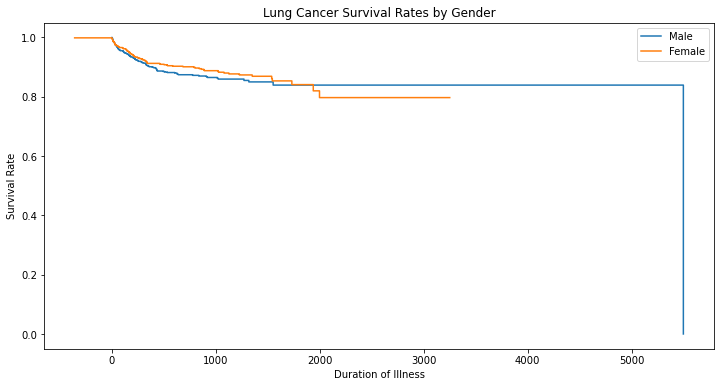

In [13]:
kmf1 = KaplanMeierFitter() ## instantiate the class to create an object

# Define duration and death indicators 
T = lung_df['duration']     ## time to event
E = lung_df['died'] 

## Two Cohorts are compared. 1. Male, 2. Female.
groups = lung_df['sex']   
i1 = (groups == 'Male')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Female')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Male')
a1 = kmf1.plot(ci_show=False)

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Female')
kmf1.plot(ax=a1, ci_show=False)

# Add Title Info 
plt.title("Lung Cancer Survival Rates by Gender")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

### Lung Cancer Survival Rate by Race

Text(0.5, 0, 'Duration of Illness')

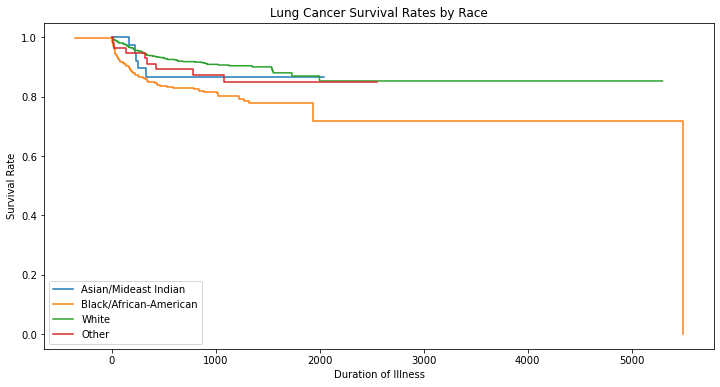

In [14]:
kmf2 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Asian/Mideast Indian, 2. Black/African-American. 3. White. 4. Other 
groups = lung_df['race_grouped']   
i1 = (groups == 'Asian/Mideast Indian')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Black/African-American')     ## group i2 , having the pandas series for the 2nd cohort
i3 = (groups == 'White')     ## group i3 , having the pandas series for the 3rd cohort
i4 = (groups == 'Other')     ## group i4 , having the pandas series for the 4th cohort


## fit the model for 1st cohort
kmf2.fit(T[i1], E[i1], label='Asian/Mideast Indian')
a1 = kmf2.plot(ci_show=False)

## fit the model for 2nd cohort
kmf2.fit(T[i2], E[i2], label='Black/African-American')
kmf2.plot(ci_show=False)

## fit the model for 3rd cohort
kmf2.fit(T[i3], E[i3], label='White')
kmf2.plot(ci_show=False)

## fit the model for 4th cohort 
kmf2.fit(T[i4], E[i4], label='Other')
kmf2.plot(ci_show=False)

# Add Title Info 
plt.title("Lung Cancer Survival Rates by Race")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

### Lung Cancer survival rate by decile 

Text(0.5, 0, 'Duration of Illness')

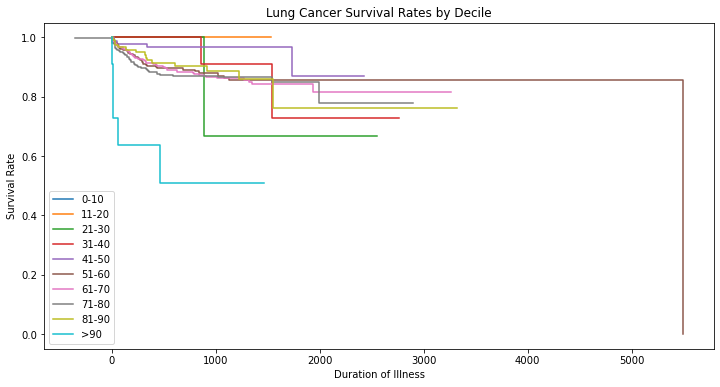

In [15]:
kmf3 = KaplanMeierFitter() ## instantiate the class to create an object

## Cohorts are divided into deciles 
groups = lung_df['deciles']   
i1 = (groups == '0-10')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == '11-20')     ## group i2 , having the pandas series for the 2nd cohort
i3 = (groups == '21-30')     ## group i3 , having the pandas series for the 3rd cohort
i4 = (groups == '31-40')     ## group i4 , having the pandas series for the 4th cohort
i5 = (groups == '41-50')     ## group i5 , having the pandas series for the 5th cohort
i6 = (groups == '51-60')     ## group i6 , having the pandas series for the 6th cohort
i7 = (groups == '61-70')     ## group i7 , having the pandas series for the 7th cohort
i8 = (groups == '71-80')     ## group i8 , having the pandas series for the 8th cohort
i9 = (groups == '81-90')     ## group i9 , having the pandas series for the 9th cohort
i10 = (groups == '>90')     ## group i10 , having the pandas series for the 10th cohort


## fit the model for 1st cohort
kmf3.fit(T[i1], E[i1], label='0-10')
a1 = kmf3.plot(ci_show=False)

## fit the model for 2nd cohort
kmf3.fit(T[i2], E[i2], label='11-20')
kmf3.plot(ci_show=False)

## fit the model for 3rd cohort
kmf3.fit(T[i3], E[i3], label='21-30')
kmf3.plot(ci_show=False)

## fit the model for 4th cohort 
kmf3.fit(T[i4], E[i4], label='31-40')
kmf3.plot(ci_show=False)

## fit the model for 5th cohort 
kmf3.fit(T[i5], E[i5], label='41-50')
kmf3.plot(ci_show=False)

## fit the model for 6th cohort 
kmf3.fit(T[i6], E[i6], label='51-60')
kmf3.plot(ci_show=False)

## fit the model for 7th cohort 
kmf3.fit(T[i7], E[i7], label='61-70')
kmf3.plot(ci_show=False)

## fit the model for 8th cohort 
kmf3.fit(T[i8], E[i8], label='71-80')
kmf3.plot(ci_show=False)

## fit the model for 9th cohort 
kmf3.fit(T[i9], E[i9], label='81-90')
kmf3.plot(ci_show=False)

## fit the model for 10th cohort 
kmf3.fit(T[i10], E[i10], label='>90')
kmf3.plot(ci_show=False)

# Add Title Info 
plt.title("Lung Cancer Survival Rates by Decile")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

## Pancreas Cancer

In [16]:
# Filter for pancreas cancer patients 
pancreas_df = cancer_df[cancer_df['PANCREAS_DT'].notnull()]

# Bin patients into age categories 
bins= [0,11,21,31,41,51,61,71,81,91,110]
labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','>90']
pancreas_df['deciles'] = pd.cut(pancreas_df['pancreas_age'], bins=bins, labels=labels, right=False)

# Add field that includes duration of illness 
pancreas_df['limit'] = "2016-08-25"
pancreas_df['limit'] = pd.to_datetime(pancreas_df['limit'])
pancreas_df['duration'] = np.where(pancreas_df["died"]==1, (pancreas_df['DEATH_DATE_off'] - pancreas_df['PANCREAS_DT']).dt.days, (pancreas_df['limit'] - pancreas_df['PANCREAS_DT']).dt.days)

# Select only fields of interest 
#pancreas_df = pancreas_df[['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race_grouped', 'PANCREAS', 'PANCREAS_DT', 'died', 'pancreas_age', 'deciles', 'duration']]

pancreas_df.head()

<ipython-input-16-6f5c267fc722>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pancreas_df['deciles'] = pd.cut(pancreas_df['pancreas_age'], bins=bins, labels=labels, right=False)
<ipython-input-16-6f5c267fc722>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pancreas_df['limit'] = "2016-08-25"
<ipython-input-16-6f5c267fc722>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,...,race_grouped,died,lung_age,pancreas_age,thyroid_age,colorectal_age,melanoma_age,deciles,limit,duration
44,1955-03-10,2012-11-22,Female,Black/African-American,0,1,0,0,0,NaT,...,Black/African-American,1,NaN,57.0,NaN,NaN,NaN,51-60,2016-08-25,41.0
55,1929-06-27,NaT,Female,Black/African-American,0,1,0,0,0,NaT,...,Black/African-American,0,NaN,86.0,NaN,NaN,NaN,81-90,2016-08-25,211.0
57,1938-06-24,NaT,Male,White,0,1,0,0,0,NaT,...,White,0,NaN,75.0,NaN,NaN,NaN,71-80,2016-08-25,1010.0
92,1952-08-30,2016-11-21,Male,Black/African-American,0,1,0,0,0,NaT,...,Black/African-American,0,NaN,62.0,NaN,NaN,NaN,61-70,2016-08-25,668.0
118,1956-07-15,2016-04-22,Male,Black/African-American,0,1,0,0,0,NaT,...,Black/African-American,1,NaN,59.0,NaN,NaN,NaN,51-60,2016-08-25,40.0


### Pancreas Cancer Survival Rate Array 

In [17]:
cancer_km(pancreas_df)

,Kaplan Meier Estimate
timeline,
0.0,1.000000
4.0,0.998480
8.0,0.996960
9.0,0.996960
25.0,0.996960
...,...
2368.0,0.942883
2402.0,0.942883
2408.0,0.942883


### Pancreas Cancer Survival Rates by Gender 

Text(0.5, 0, 'Duration of Illness')

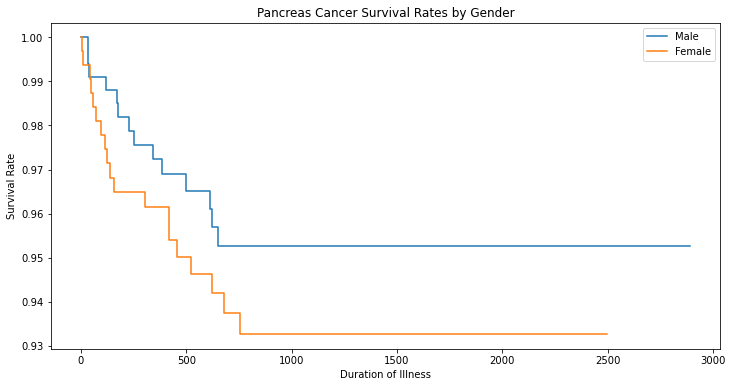

In [18]:
kmf4 = KaplanMeierFitter() ## instantiate the class to create an object

# Define duration and death indicators 
T_pancreas = pancreas_df['duration']     ## time to event
E_pancreas = pancreas_df['died']         ## indicator for patient death

## Two Cohorts are compared. 1. Male, 2. Female.
groups = pancreas_df['sex']   
i1 = (groups == 'Male')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Female')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf4.fit(T_pancreas[i1], E_pancreas[i1], label='Male')
a1 = kmf4.plot(ci_show=False)

## fit the model for 2nd cohort
kmf4.fit(T_pancreas[i2], E_pancreas[i2], label='Female')
kmf4.plot(ci_show=False)

# Add Title Info 
plt.title("Pancreas Cancer Survival Rates by Gender")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

### Pancreas Cancer Survival Rates by Race

Text(0.5, 0, 'Duration of Illness')

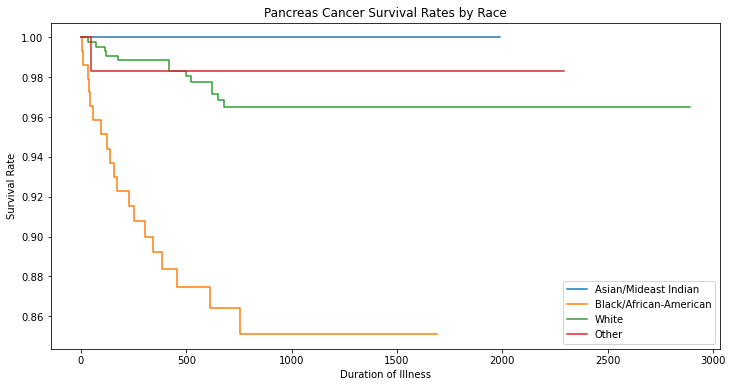

In [19]:
kmf5 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Asian/Mideast Indian, 2. Black/African-American. 3. White. 4. Other 
groups = pancreas_df['race_grouped']   
i1 = (groups == 'Asian/Mideast Indian')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Black/African-American')     ## group i2 , having the pandas series for the 2nd cohort
i3 = (groups == 'White')     ## group i3 , having the pandas series for the 3rd cohort
i4 = (groups == 'Other')     ## group i4 , having the pandas series for the 4th cohort


## fit the model for 1st cohort
kmf5.fit(T_pancreas[i1], E_pancreas[i1], label='Asian/Mideast Indian')
a1 = kmf5.plot(ci_show=False)

## fit the model for 2nd cohort
kmf5.fit(T_pancreas[i2], E_pancreas[i2], label='Black/African-American')
kmf5.plot(ci_show=False)

## fit the model for 3rd cohort
kmf5.fit(T_pancreas[i3], E_pancreas[i3], label='White')
kmf5.plot(ci_show=False)

## fit the model for 4th cohort 
kmf5.fit(T_pancreas[i4], E_pancreas[i4], label='Other')
kmf5.plot(ci_show=False)

# Add Title Info 
plt.title("Pancreas Cancer Survival Rates by Race")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

### Pancreas Cancer Survival Rates by Decile

Text(0.5, 0, 'Duration of Illness')

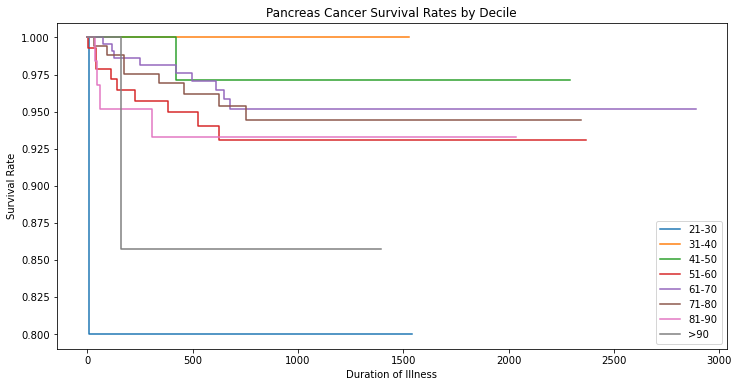

In [20]:
kmf6 = KaplanMeierFitter() ## instantiate the class to create an object

## Cohorts are divided into deciles 
groups = pancreas_df['deciles']   
#i1 = (groups == '0-10')      ## no patients in this age range 
#i2 = (groups == '11-20')     ## no patients in this age range 
i3 = (groups == '21-30')     ## group i3 , having the pandas series for the 3rd cohort
i4 = (groups == '31-40')     ## group i4 , having the pandas series for the 4th cohort
i5 = (groups == '41-50')     ## group i5 , having the pandas series for the 5th cohort
i6 = (groups == '51-60')     ## group i6 , having the pandas series for the 6th cohort
i7 = (groups == '61-70')     ## group i7 , having the pandas series for the 7th cohort
i8 = (groups == '71-80')     ## group i8 , having the pandas series for the 8th cohort
i9 = (groups == '81-90')     ## group i9 , having the pandas series for the 9th cohort
i10 = (groups == '>90')     ## group i10 , having the pandas series for the 10th cohort


## fit the model for 1st cohort
#kmf6.fit(T_pancreas[i1], E_pancreas[i1], label='0-10')
#a1 = kmf6.plot(ci_show=False)

## fit the model for 2nd cohort
#kmf6.fit(T_pancreas[i2], E_pancreas[i2], label='11-20')
#kmf6.plot(ci_show=False)

## fit the model for 3rd cohort
kmf6.fit(T_pancreas[i3], E_pancreas[i3], label='21-30')
kmf6.plot(ci_show=False)

## fit the model for 4th cohort 
kmf6.fit(T_pancreas[i4], E_pancreas[i4], label='31-40')
kmf6.plot(ci_show=False)

## fit the model for 5th cohort 
kmf6.fit(T_pancreas[i5], E_pancreas[i5], label='41-50')
kmf6.plot(ci_show=False)

## fit the model for 6th cohort 
kmf6.fit(T_pancreas[i6], E_pancreas[i6], label='51-60')
kmf6.plot(ci_show=False)

## fit the model for 7th cohort 
kmf6.fit(T_pancreas[i7], E_pancreas[i7], label='61-70')
kmf6.plot(ci_show=False)

## fit the model for 8th cohort 
kmf6.fit(T_pancreas[i8], E_pancreas[i8], label='71-80')
kmf6.plot(ci_show=False)

## fit the model for 9th cohort 
kmf6.fit(T_pancreas[i9], E_pancreas[i9], label='81-90')
kmf6.plot(ci_show=False)

## fit the model for 10th cohort 
kmf6.fit(T_pancreas[i10], E_pancreas[i10], label='>90')
kmf6.plot(ci_show=False)

# Add Title Info 
plt.title("Pancreas Cancer Survival Rates by Decile")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

## Thyroid Cancer

In [21]:
# Filter for thyroid cancer patients 
thyroid_df = cancer_df[cancer_df['THYROID_DT'].notnull()]

# Bin patients into age categories 
bins= [0,11,21,31,41,51,61,71,81,91,110]
labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','>90']
thyroid_df['deciles'] = pd.cut(thyroid_df['thyroid_age'], bins=bins, labels=labels, right=False)

# Add field that includes duration of illness 
thyroid_df['limit'] = "2016-08-25"
thyroid_df['limit'] = pd.to_datetime(thyroid_df['limit'])
thyroid_df['duration'] = np.where(thyroid_df["died"]==1, (thyroid_df['DEATH_DATE_off'] - thyroid_df['THYROID_DT']).dt.days, (thyroid_df['limit'] - thyroid_df['THYROID_DT']).dt.days)

# Select only fields of interest 
#thyroid_df = thyroid_df[['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race_grouped', 'THYROID', 'THYROID_DT', 'died', 'thyroid_age', 'deciles', 'duration']]

thyroid_df.head()

<ipython-input-21-e4a5dd1e9e54>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thyroid_df['deciles'] = pd.cut(thyroid_df['thyroid_age'], bins=bins, labels=labels, right=False)
<ipython-input-21-e4a5dd1e9e54>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thyroid_df['limit'] = "2016-08-25"
<ipython-input-21-e4a5dd1e9e54>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,...,race_grouped,died,lung_age,pancreas_age,thyroid_age,colorectal_age,melanoma_age,deciles,limit,duration
6,1946-11-03,NaT,Female,Black/African-American,0,0,1,0,0,NaT,...,Black/African-American,0,NaN,NaN,66.0,NaN,NaN,61-70,2016-08-25,1365.0
7,1938-06-10,NaT,Female,Black/African-American,0,0,1,0,0,NaT,...,Black/African-American,0,NaN,NaN,74.0,NaN,NaN,71-80,2016-08-25,1523.0
28,1948-02-17,NaT,Female,Black/African-American,0,0,1,0,0,NaT,...,Black/African-American,0,NaN,NaN,64.0,NaN,NaN,61-70,2016-08-25,1453.0
32,1949-09-04,NaT,Female,White,0,0,1,0,0,NaT,...,White,0,NaN,NaN,64.0,NaN,NaN,61-70,2016-08-25,890.0
98,1949-12-15,NaT,Female,Black/African-American,0,0,1,0,0,NaT,...,Black/African-American,0,NaN,NaN,63.0,NaN,NaN,61-70,2016-08-25,1276.0


### Thyroid Cancer Survival Rate Array

In [22]:
cancer_km(thyroid_df)

,Kaplan Meier Estimate
timeline,
0.0,0.998656
78.0,0.998656
106.0,0.998656
108.0,0.998656
109.0,0.998656
...,...
13700.0,0.955013
13732.0,0.955013
14498.0,0.955013


### Thyroid Cancer Survival Rates by Gender

Text(0.5, 0, 'Duration of Illness')

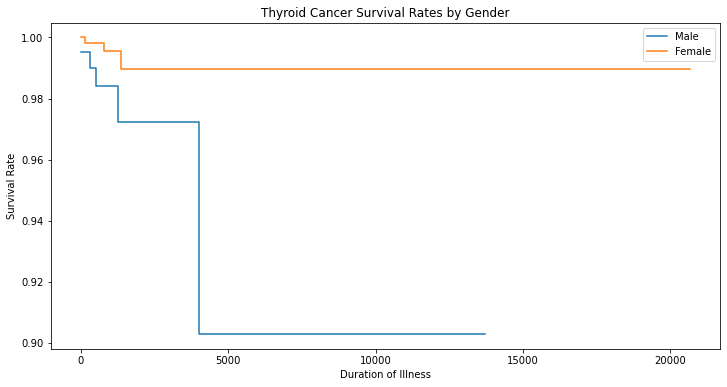

In [23]:
kmf7 = KaplanMeierFitter() ## instantiate the class to create an object

# Define duration and death indicators 
T_thyroid = thyroid_df['duration']     ## time to event
E_thyroid = thyroid_df['died']         ## indicator for patient death

## Two Cohorts are compared. 1. Male, 2. Female.
groups = thyroid_df['sex']   
i1 = (groups == 'Male')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Female')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf7.fit(T_thyroid[i1], E_thyroid[i1], label='Male')
a1 = kmf7.plot(ci_show=False)

## fit the model for 2nd cohort
kmf7.fit(T_thyroid[i2], E_thyroid[i2], label='Female')
kmf7.plot(ci_show=False)

# Add Title Info 
plt.title("Thyroid Cancer Survival Rates by Gender")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

### Thyroid Cancer Survival Rates by Race

Text(0.5, 0, 'Duration of Illness')

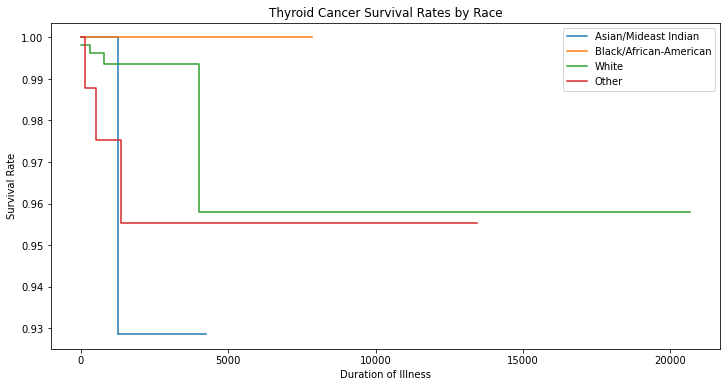

In [24]:
kmf8 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Asian/Mideast Indian, 2. Black/African-American. 3. White. 4. Other 
groups = thyroid_df['race_grouped']   
i1 = (groups == 'Asian/Mideast Indian')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Black/African-American')     ## group i2 , having the pandas series for the 2nd cohort
i3 = (groups == 'White')     ## group i3 , having the pandas series for the 3rd cohort
i4 = (groups == 'Other')     ## group i4 , having the pandas series for the 4th cohort


## fit the model for 1st cohort
kmf8.fit(T_thyroid[i1], E_thyroid[i1], label='Asian/Mideast Indian')
a1 = kmf8.plot(ci_show=False)

## fit the model for 2nd cohort
kmf8.fit(T_thyroid[i2], E_thyroid[i2], label='Black/African-American')
kmf8.plot(ci_show=False)

## fit the model for 3rd cohort
kmf8.fit(T_thyroid[i3], E_thyroid[i3], label='White')
kmf8.plot(ci_show=False)

## fit the model for 4th cohort 
kmf8.fit(T_thyroid[i4], E_thyroid[i4], label='Other')
kmf8.plot(ci_show=False)

# Add Title Info 
plt.title("Thyroid Cancer Survival Rates by Race")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

### Thyroid Cancer Survival Rates by Decile

Text(0.5, 0, 'Duration of Illness')

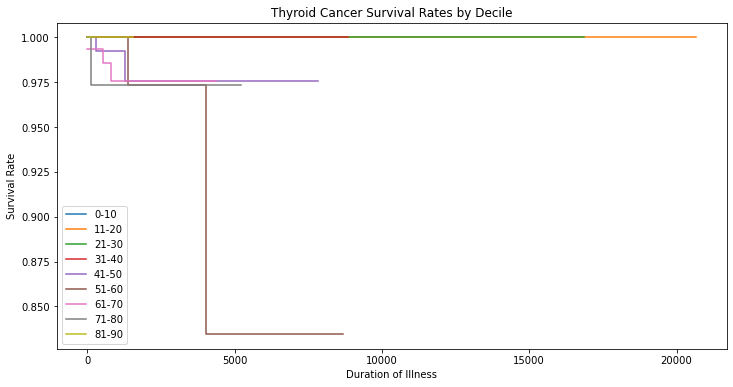

In [25]:
kmf9 = KaplanMeierFitter() ## instantiate the class to create an object

## Cohorts are divided into deciles 
groups = thyroid_df['deciles']   
i1 = (groups == '0-10')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == '11-20')     ## group i2 , having the pandas series for the 2nd cohort
i3 = (groups == '21-30')     ## group i3 , having the pandas series for the 3rd cohort
i4 = (groups == '31-40')     ## group i4 , having the pandas series for the 4th cohort
i5 = (groups == '41-50')     ## group i5 , having the pandas series for the 5th cohort
i6 = (groups == '51-60')     ## group i6 , having the pandas series for the 6th cohort
i7 = (groups == '61-70')     ## group i7 , having the pandas series for the 7th cohort
i8 = (groups == '71-80')     ## group i8 , having the pandas series for the 8th cohort
i9 = (groups == '81-90')     ## group i9 , having the pandas series for the 9th cohort
#i10 = (groups == '>90')     ## no patients in this group


## fit the model for 1st cohort
kmf9.fit(T_thyroid[i1], E_thyroid[i1], label='0-10')
a1 = kmf9.plot(ci_show=False)

## fit the model for 2nd cohort
kmf9.fit(T_thyroid[i2], E_thyroid[i2], label='11-20')
kmf9.plot(ci_show=False)

## fit the model for 3rd cohort
kmf9.fit(T_thyroid[i3], E_thyroid[i3], label='21-30')
kmf9.plot(ci_show=False)

## fit the model for 4th cohort 
kmf9.fit(T_thyroid[i4], E_thyroid[i4], label='31-40')
kmf9.plot(ci_show=False)

## fit the model for 5th cohort 
kmf9.fit(T_thyroid[i5], E_thyroid[i5], label='41-50')
kmf9.plot(ci_show=False)

## fit the model for 6th cohort 
kmf9.fit(T_thyroid[i6], E_thyroid[i6], label='51-60')
kmf9.plot(ci_show=False)

## fit the model for 7th cohort 
kmf9.fit(T_thyroid[i7], E_thyroid[i7], label='61-70')
kmf9.plot(ci_show=False)

## fit the model for 8th cohort 
kmf9.fit(T_thyroid[i8], E_thyroid[i8], label='71-80')
kmf9.plot(ci_show=False)

## fit the model for 9th cohort 
kmf9.fit(T_thyroid[i9], E_thyroid[i9], label='81-90')
kmf9.plot(ci_show=False)

## fit the model for 10th cohort 
#kmf9.fit(T_thyroid[i10], E_thyroid[i10], label='>90')
#kmf9.plot(ci_show=False)

# Add Title Info 
plt.title("Thyroid Cancer Survival Rates by Decile")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

## Colorectal Cancer

In [26]:
# Filter for colorectal cancer patients 
colorectal_df = cancer_df[cancer_df['COLORECTAL_DT'].notnull()]

# Bin patients into age categories 
bins= [0,11,21,31,41,51,61,71,81,91,110]
labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','>90']
colorectal_df['deciles'] = pd.cut(colorectal_df['colorectal_age'], bins=bins, labels=labels, right=False)

# Add field that includes duration of illness 
colorectal_df['limit'] = "2016-08-25"
colorectal_df['limit'] = pd.to_datetime(colorectal_df['limit'])
colorectal_df['duration'] = np.where(colorectal_df["died"]==1, (colorectal_df['DEATH_DATE_off'] - colorectal_df['COLORECTAL_DT']).dt.days, (colorectal_df['limit'] - colorectal_df['COLORECTAL_DT']).dt.days)

# Select only fields of interest 
#colorectal_df = colorectal_df[['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race_grouped', 'COLORECTAL', 'COLORECTAL_DT', 'died', 'colorectal_age', 'deciles', 'duration']]

colorectal_df.head()

<ipython-input-26-9e34d1fcadc6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colorectal_df['deciles'] = pd.cut(colorectal_df['colorectal_age'], bins=bins, labels=labels, right=False)
<ipython-input-26-9e34d1fcadc6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colorectal_df['limit'] = "2016-08-25"
<ipython-input-26-9e34d1fcadc6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,...,race_grouped,died,lung_age,pancreas_age,thyroid_age,colorectal_age,melanoma_age,deciles,limit,duration
13,1971-08-11,NaT,Female,Black/African-American,0,0,0,1,0,NaT,...,Black/African-American,0,NaN,NaN,NaN,42.0,NaN,41-50,2016-08-25,967.0
14,1948-03-22,2016-01-07,Female,Black/African-American,0,0,0,1,0,NaT,...,Black/African-American,1,NaN,NaN,NaN,66.0,NaN,61-70,2016-08-25,464.0
16,1946-01-09,NaT,Female,Black/African-American,0,0,0,1,0,NaT,...,Black/African-American,0,NaN,NaN,NaN,67.0,NaN,61-70,2016-08-25,1076.0
36,1970-12-19,NaT,Female,White,0,0,0,1,0,NaT,...,White,0,NaN,NaN,NaN,42.0,NaN,41-50,2016-08-25,990.0
41,1928-03-25,NaT,Female,Black/African-American,1,0,0,1,0,2012-02-22,...,Black/African-American,0,83.0,NaN,NaN,85.0,NaN,81-90,2016-08-25,988.0


### Colorectal Survival Rate Array

In [27]:
cancer_km(colorectal_df)

,Kaplan Meier Estimate
timeline,
0.0,0.997886
7.0,0.996829
9.0,0.995772
26.0,0.994715
28.0,0.993658
...,...
5146.0,0.744286
5279.0,0.744286
5409.0,0.744286


### Colorectal Cancer Survival Rates by Gender

Text(0.5, 0, 'Duration of Illness')

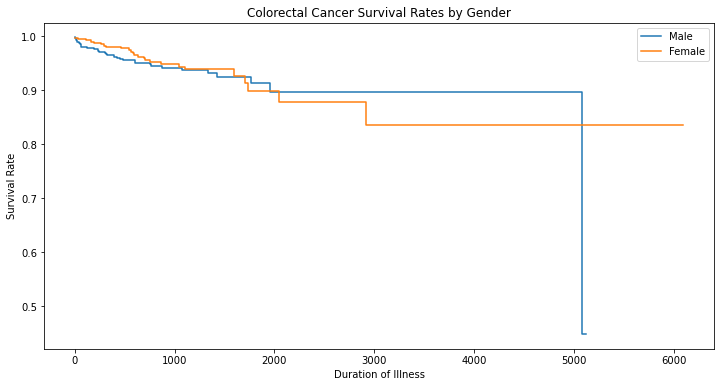

In [28]:
kmf10 = KaplanMeierFitter() ## instantiate the class to create an object

# Define duration and death indicators 
T_colorectal = colorectal_df['duration']     ## time to event
E_colorectal = colorectal_df['died']         ## indicator for patient death

## Two Cohorts are compared. 1. Male, 2. Female.
groups = colorectal_df['sex']   
i1 = (groups == 'Male')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Female')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf10.fit(T_colorectal[i1], E_colorectal[i1], label='Male')
a1 = kmf10.plot(ci_show=False)

## fit the model for 2nd cohort
kmf10.fit(T_colorectal[i2], E_colorectal[i2], label='Female')
kmf10.plot(ci_show=False)

# Add Title Info 
plt.title("Colorectal Cancer Survival Rates by Gender")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

### Colorectal Cancer Survival Rates by Race

Text(0.5, 0, 'Duration of Illness')

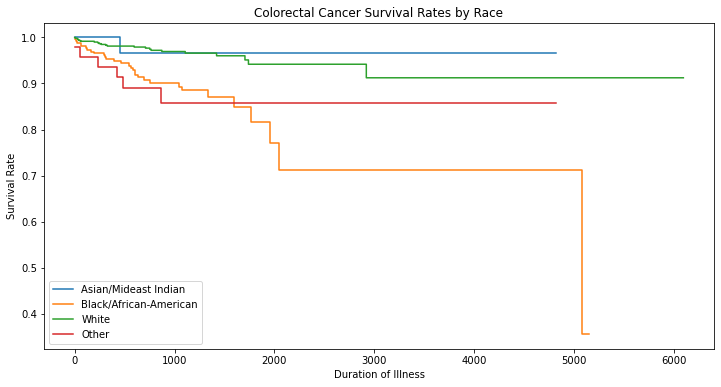

In [29]:
kmf11 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Asian/Mideast Indian, 2. Black/African-American. 3. White. 4. Other 
groups = colorectal_df['race_grouped']   
i1 = (groups == 'Asian/Mideast Indian')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Black/African-American')     ## group i2 , having the pandas series for the 2nd cohort
i3 = (groups == 'White')     ## group i3 , having the pandas series for the 3rd cohort
i4 = (groups == 'Other')     ## group i4 , having the pandas series for the 4th cohort


## fit the model for 1st cohort
kmf11.fit(T_colorectal[i1], E_colorectal[i1], label='Asian/Mideast Indian')
a1 = kmf11.plot(ci_show=False)

## fit the model for 2nd cohort
kmf11.fit(T_colorectal[i2], E_colorectal[i2], label='Black/African-American')
kmf11.plot(ci_show=False)

## fit the model for 3rd cohort
kmf11.fit(T_colorectal[i3], E_colorectal[i3], label='White')
kmf11.plot(ci_show=False)

## fit the model for 4th cohort 
kmf11.fit(T_colorectal[i4], E_colorectal[i4], label='Other')
kmf11.plot(ci_show=False)

# Add Title Info 
plt.title("Colorectal Cancer Survival Rates by Race")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

### Colorectal Cancer Survival Rates by Decile

Text(0.5, 0, 'Duration of Illness')

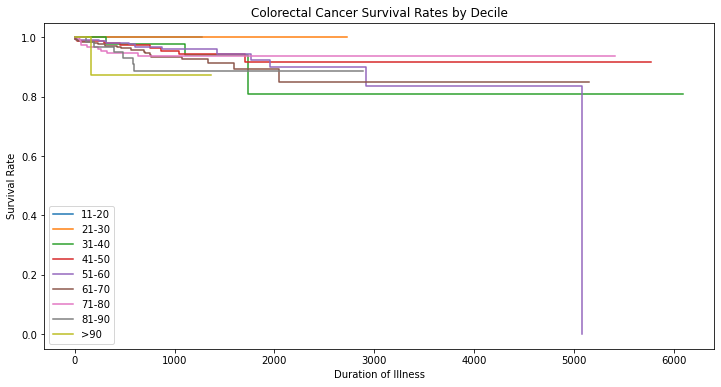

In [30]:
kmf12 = KaplanMeierFitter() ## instantiate the class to create an object

## Cohorts are divided into deciles 
groups = colorectal_df['deciles']   
#i1 = (groups == '0-10')      ## no patients in this decile 
i2 = (groups == '11-20')     ## group i2 , having the pandas series for the 2nd cohort
i3 = (groups == '21-30')     ## group i3 , having the pandas series for the 3rd cohort
i4 = (groups == '31-40')     ## group i4 , having the pandas series for the 4th cohort
i5 = (groups == '41-50')     ## group i5 , having the pandas series for the 5th cohort
i6 = (groups == '51-60')     ## group i6 , having the pandas series for the 6th cohort
i7 = (groups == '61-70')     ## group i7 , having the pandas series for the 7th cohort
i8 = (groups == '71-80')     ## group i8 , having the pandas series for the 8th cohort
i9 = (groups == '81-90')     ## group i9 , having the pandas series for the 9th cohort
i10 = (groups == '>90')     ## no patients in this group


## fit the model for 1st cohort
#kmf12.fit(T_thyroid[i1], E_thyroid[i1], label='0-10')
#a1 = kmf12.plot(ci_show=False)

## fit the model for 2nd cohort
kmf12.fit(T_colorectal[i2], E_colorectal[i2], label='11-20')
kmf12.plot(ci_show=False)

## fit the model for 3rd cohort
kmf12.fit(T_colorectal[i3], E_colorectal[i3], label='21-30')
kmf12.plot(ci_show=False)

## fit the model for 4th cohort 
kmf12.fit(T_colorectal[i4], E_colorectal[i4], label='31-40')
kmf12.plot(ci_show=False)

## fit the model for 5th cohort 
kmf12.fit(T_colorectal[i5], E_colorectal[i5], label='41-50')
kmf12.plot(ci_show=False)

## fit the model for 6th cohort 
kmf12.fit(T_colorectal[i6], E_colorectal[i6], label='51-60')
kmf12.plot(ci_show=False)

## fit the model for 7th cohort 
kmf12.fit(T_colorectal[i7], E_colorectal[i7], label='61-70')
kmf12.plot(ci_show=False)

## fit the model for 8th cohort 
kmf12.fit(T_colorectal[i8], E_colorectal[i8], label='71-80')
kmf12.plot(ci_show=False)

## fit the model for 9th cohort 
kmf12.fit(T_colorectal[i9], E_colorectal[i9], label='81-90')
kmf12.plot(ci_show=False)

## fit the model for 10th cohort 
kmf12.fit(T_colorectal[i10], E_colorectal[i10], label='>90')
kmf12.plot(ci_show=False)

# Add Title Info 
plt.title("Colorectal Cancer Survival Rates by Decile")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

## Melanoma Cancer

In [31]:
# Filter for melanoma cancer patients 
melanoma_df = cancer_df[cancer_df['MELANOMA_DT'].notnull()]

# Bin patients into age categories 
bins= [0,11,21,31,41,51,61,71,81,91,110]
labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','>90']
melanoma_df['deciles'] = pd.cut(melanoma_df['melanoma_age'], bins=bins, labels=labels, right=False)

# Add field that includes duration of illness 
melanoma_df['limit'] = "2016-08-25"
melanoma_df['limit'] = pd.to_datetime(melanoma_df['limit'])
melanoma_df['duration'] = np.where(melanoma_df["died"]==1, (melanoma_df['DEATH_DATE_off'] - melanoma_df['MELANOMA_DT']).dt.days, (melanoma_df['limit'] - melanoma_df['MELANOMA_DT']).dt.days)

# Select only fields of interest 
#melanoma_df = melanoma_df[['BIRTH_DATE_off', 'DEATH_DATE_off', 'sex', 'race_grouped', 'MELANOMA', 'MELANOMA_DT', 'died', 'melanoma_age', 'deciles', 'duration']]

melanoma_df.head()

<ipython-input-31-ce63222caa26>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melanoma_df['deciles'] = pd.cut(melanoma_df['melanoma_age'], bins=bins, labels=labels, right=False)
<ipython-input-31-ce63222caa26>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melanoma_df['limit'] = "2016-08-25"
<ipython-input-31-ce63222caa26>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,...,race_grouped,died,lung_age,pancreas_age,thyroid_age,colorectal_age,melanoma_age,deciles,limit,duration
146,1928-06-22,NaT,Male,White,0,0,0,0,1,NaT,...,White,0,NaN,NaN,NaN,NaN,86.0,81-90,2016-08-25,541.0
178,1933-12-27,2014-11-27,Male,White,0,0,0,0,1,NaT,...,White,1,NaN,NaN,NaN,NaN,78.0,71-80,2016-08-25,707.0
196,1924-04-08,NaT,Female,White,0,0,0,0,1,NaT,...,White,0,NaN,NaN,NaN,NaN,90.0,81-90,2016-08-25,817.0
341,1957-10-04,NaT,Female,White,0,0,0,0,1,NaT,...,White,0,NaN,NaN,NaN,NaN,55.0,51-60,2016-08-25,1194.0
354,1966-08-03,NaT,Male,White,0,0,0,0,1,NaT,...,White,0,NaN,NaN,NaN,NaN,48.0,41-50,2016-08-25,535.0


### Melanoma Cancer Survival Array 

In [32]:
cancer_km(melanoma_df)

,Kaplan Meier Estimate
timeline,
0.0,0.997110
29.0,0.997110
55.0,0.994211
71.0,0.994211
82.0,0.994211
...,...
7227.0,0.711870
8070.0,0.711870
8710.0,0.711870


### Melanoma Cancer Survival Rates by Gender

Text(0.5, 0, 'Duration of Illness')

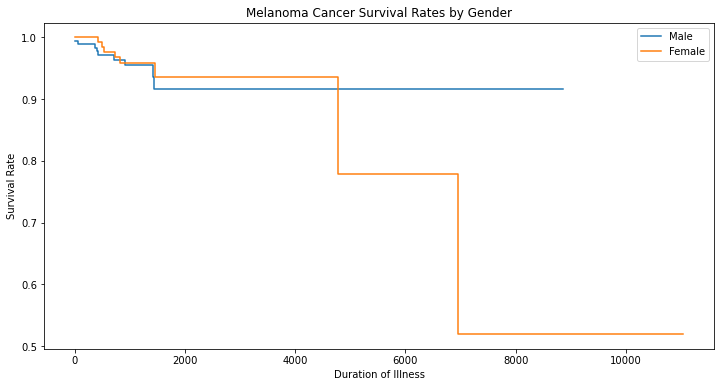

In [33]:
kmf13 = KaplanMeierFitter() ## instantiate the class to create an object

# Define duration and death indicators 
T_melanoma = melanoma_df['duration']     ## time to event
E_melanoma = melanoma_df['died']         ## indicator for patient death

## Two Cohorts are compared. 1. Male, 2. Female.
groups = melanoma_df['sex']   
i1 = (groups == 'Male')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Female')     ## group i2 , having the pandas series for the 2nd cohort


## fit the model for 1st cohort
kmf13.fit(T_melanoma[i1], E_melanoma[i1], label='Male')
a1 = kmf13.plot(ci_show=False)

## fit the model for 2nd cohort
kmf13.fit(T_melanoma[i2], E_melanoma[i2], label='Female')
kmf13.plot(ci_show=False)

# Add Title Info 
plt.title("Melanoma Cancer Survival Rates by Gender")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

### Melanoma Cancer Survival Rates by Race

Text(0.5, 0, 'Duration of Illness')

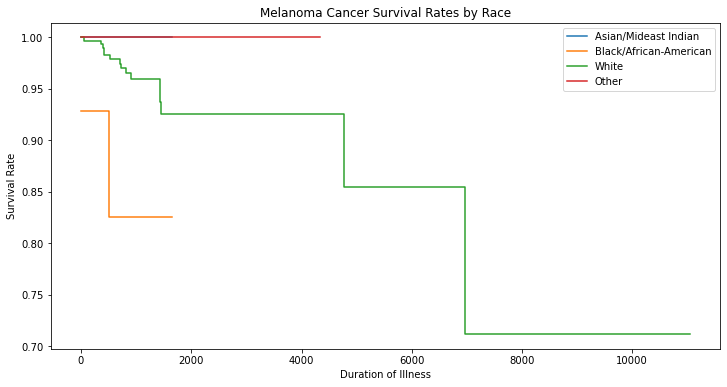

In [34]:
kmf14 = KaplanMeierFitter() ## instantiate the class to create an object

## Two Cohorts are compared. 1. Asian/Mideast Indian, 2. Black/African-American. 3. White. 4. Other 
groups = melanoma_df['race_grouped']   
i1 = (groups == 'Asian/Mideast Indian')      ## group i1 , having the pandas series for the 1st cohort
i2 = (groups == 'Black/African-American')     ## group i2 , having the pandas series for the 2nd cohort
i3 = (groups == 'White')     ## group i3 , having the pandas series for the 3rd cohort
i4 = (groups == 'Other')     ## group i4 , having the pandas series for the 4th cohort


## fit the model for 1st cohort
kmf14.fit(T_melanoma[i1], E_melanoma[i1], label='Asian/Mideast Indian')
a1 = kmf14.plot(ci_show=False)

## fit the model for 2nd cohort
kmf14.fit(T_melanoma[i2], E_melanoma[i2], label='Black/African-American')
kmf14.plot(ci_show=False)

## fit the model for 3rd cohort
kmf14.fit(T_melanoma[i3], E_melanoma[i3], label='White')
kmf14.plot(ci_show=False)

## fit the model for 4th cohort 
kmf14.fit(T_melanoma[i4], E_melanoma[i4], label='Other')
kmf14.plot(ci_show=False)

# Add Title Info 
plt.title("Melanoma Cancer Survival Rates by Race")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

### Melanoma Cancer Survival Rates by Decile

Text(0.5, 0, 'Duration of Illness')

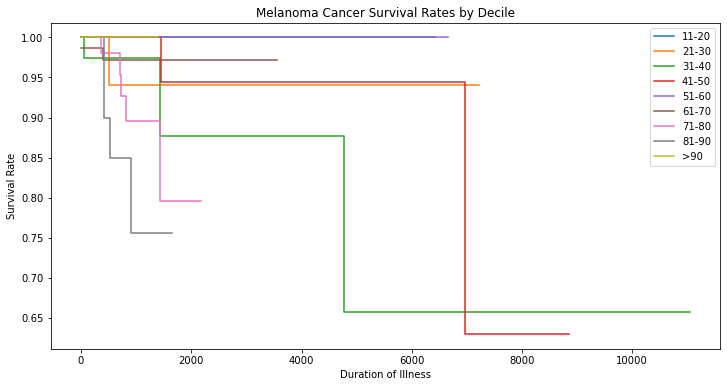

In [35]:
kmf15 = KaplanMeierFitter() ## instantiate the class to create an object

## Cohorts are divided into deciles 
groups = melanoma_df['deciles']   
#i1 = (groups == '0-10')      ## no patients in this decile 
i2 = (groups == '11-20')     ## group i2 , having the pandas series for the 2nd cohort
i3 = (groups == '21-30')     ## group i3 , having the pandas series for the 3rd cohort
i4 = (groups == '31-40')     ## group i4 , having the pandas series for the 4th cohort
i5 = (groups == '41-50')     ## group i5 , having the pandas series for the 5th cohort
i6 = (groups == '51-60')     ## group i6 , having the pandas series for the 6th cohort
i7 = (groups == '61-70')     ## group i7 , having the pandas series for the 7th cohort
i8 = (groups == '71-80')     ## group i8 , having the pandas series for the 8th cohort
i9 = (groups == '81-90')     ## group i9 , having the pandas series for the 9th cohort
i10 = (groups == '>90')     ## no patients in this group


## fit the model for 1st cohort
#kmf12.fit(T_thyroid[i1], E_thyroid[i1], label='0-10')
#a1 = kmf12.plot(ci_show=False)

## fit the model for 2nd cohort
kmf15.fit(T_melanoma[i2], E_melanoma[i2], label='11-20')
kmf15.plot(ci_show=False)

## fit the model for 3rd cohort
kmf15.fit(T_melanoma[i3], E_melanoma[i3], label='21-30')
kmf15.plot(ci_show=False)

## fit the model for 4th cohort 
kmf15.fit(T_melanoma[i4], E_melanoma[i4], label='31-40')
kmf15.plot(ci_show=False)

## fit the model for 5th cohort 
kmf15.fit(T_melanoma[i5], E_melanoma[i5], label='41-50')
kmf15.plot(ci_show=False)

## fit the model for 6th cohort 
kmf15.fit(T_melanoma[i6], E_melanoma[i6], label='51-60')
kmf15.plot(ci_show=False)

## fit the model for 7th cohort 
kmf15.fit(T_melanoma[i7], E_melanoma[i7], label='61-70')
kmf15.plot(ci_show=False)

## fit the model for 8th cohort 
kmf15.fit(T_melanoma[i8], E_melanoma[i8], label='71-80')
kmf15.plot(ci_show=False)

## fit the model for 9th cohort 
kmf15.fit(T_melanoma[i9], E_melanoma[i9], label='81-90')
kmf15.plot(ci_show=False)

## fit the model for 10th cohort 
kmf15.fit(T_melanoma[i10], E_melanoma[i10], label='>90')
kmf15.plot(ci_show=False)

# Add Title Info 
plt.title("Melanoma Cancer Survival Rates by Decile")
plt.ylabel("Survival Rate")
plt.xlabel("Duration of Illness")

## Answer Homework Questions

### Bind together individual cancer datasets for grouping purposes 

In [36]:
cancer_revised = lung_df.append(pd.DataFrame(data = pancreas_df), ignore_index=True)
cancer_revised = cancer_revised.append(pd.DataFrame(data = thyroid_df), ignore_index=True)
cancer_revised = cancer_revised.append(pd.DataFrame(data = colorectal_df), ignore_index=True)
cancer_revised = cancer_revised.append(pd.DataFrame(data = melanoma_df), ignore_index=True)

len(cancer_revised)

4177

### Create Function to retrieve specific survival rate segments

In [37]:
def km_segment(df, column, segment, duration):
    kmf = KaplanMeierFitter() ## instantiate the class to create an object

    # Define duration and death indicators 
    T = df['duration']     ## time to event
    E = df['died'] 

    
    groups = df[column]   
    i1 = (groups == segment)      ## group i1 , having the pandas series for the 1st cohort


    ## fit the model for cohort
    kmf.fit(T[i1], E[i1], label=segment)
    return kmf.predict(duration)

### 1. which cancer has the highest survival for this cohort?

Answer: Thyroid Cancer has the highest survival for this cohort.

In [38]:
cancer_km(thyroid_df)

,Kaplan Meier Estimate
timeline,
0.0,0.998656
78.0,0.998656
106.0,0.998656
108.0,0.998656
109.0,0.998656
...,...
13700.0,0.955013
13732.0,0.955013
14498.0,0.955013


### 2. which cancer has the lowest survival for this cohort?

Answer: Lung Cancer has the lowest survival for this cohort.

In [39]:
cancer_km(lung_df)

,Kaplan Meier Estimate
timeline,
-360.0,0.999326
0.0,0.998651
1.0,0.997303
2.0,0.996628
3.0,0.995954
...,...
3263.0,0.814427
3319.0,0.814427
3747.0,0.814427


### 3. how many patients had 2 cancer diagnosis?

Answer: 29 patients

In [40]:
cancer_df['multiple_cancers'] = np.where(cancer_df['LUNG']+cancer_df['PANCREAS']+cancer_df['THYROID']+cancer_df['COLORECTAL']+cancer_df['MELANOMA']>1, 1, 0)
print ('The answer is:', len(cancer_df[cancer_df.multiple_cancers==1]), 'patients')

The answer is: 29 patients


### 4. which age group has the lowest survival after 400 days since cancer diagnosis?

In [41]:
print ('0-10:', km_segment(cancer_revised, 'deciles', '0-10',400))
print ('11-20:', km_segment(cancer_revised, 'deciles', '11-20',400))
print ('21-30:', km_segment(cancer_revised, 'deciles', '21-30',400))
print ('31-40:', km_segment(cancer_revised, 'deciles', '31-40',400))
print ('41-50:', km_segment(cancer_revised, 'deciles', '41-50',400))
print ('51-60:', km_segment(cancer_revised, 'deciles', '51-60',400))
print ('61-70:', km_segment(cancer_revised, 'deciles', '61-70',400))
print ('71-80:', km_segment(cancer_revised, 'deciles', '71-80',400))
print ('81-90:', km_segment(cancer_revised, 'deciles', '81-90',400))
print ('>90:', km_segment(cancer_revised, 'deciles', '>90',400))

print('\nThe >90 age group has the lowest survival rate after 400 days since cancer diagnosis, at 0.7916')

0-10: 1.0
11-20: 1.0
21-30: 0.9913793103448278
31-40: 0.9914656432748542
41-50: 0.9849376524213672
51-60: 0.9549112752040271
61-70: 0.951279699152845
71-80: 0.9241054162151388
81-90: 0.9358971278620616
>90: 0.7916041979010496

The >90 age group has the lowest survival rate after 400 days since cancer diagnosis, at 0.7916


### 5. what is the survival rate for females with colorectal cancer after 1000 days since diagnosis?

In [42]:
print ('The answer is:', km_segment(colorectal_df, 'sex', 'Female',1000))

The answer is: 0.9484362597817692


### 6.what is the survival rate for males with lung cancer after 300 days since diagnosis?

In [43]:
print ('The answer is:', km_segment(lung_df, 'sex', 'Male',300))

The answer is: 0.9149880203162795


### 7. what is the survival rate for females with melanoma cancer after 1200 days since diagnosis?

In [44]:
print ('The answer is:', km_segment(melanoma_df, 'sex', 'Female',1200))

The answer is: 0.9587861344911673


### 8. what is the survival rate for males with thyroid cancer after 1500 days since diagnosis?

In [45]:
print ('The answer is:', km_segment(thyroid_df, 'sex', 'Male',1500))

The answer is: 0.9723197357959752


### 9. what is the survival rate for males with pancreatic cancer after 2200 days since diagnosis?

In [46]:
print ('The answer is:', km_segment(pancreas_df, 'sex', 'Male',2200))

The answer is: 0.9526692572895107


### 10. what is the survival rate for African-Americans with colorectal cancer after 2000 days since diagnosis?

In [47]:
print ('The answer is:', km_segment(colorectal_df, 'race_grouped', 'Black/African-American',2000))

The answer is: 0.7706150842786863


### 11. what is the survival rate for Whites with lung cancer after 1000 days since diagnosis?

In [48]:
print ('The answer is:', km_segment(lung_df, 'race_grouped', 'White',1000))

The answer is: 0.9092859116518297


### 12. what is the survival rate for African-Americans with melanoma cancer after 2 years since diagnosis?

In [49]:
print ('The answer is:', km_segment(melanoma_df, 'race_grouped', 'Black/African-American',730))

The answer is: 0.8253968253968252


### 13. what is the survival rate for Whites with pancreatic cancer after 3 years since diagnosis?

In [50]:
print ('The answer is:', km_segment(pancreas_df, 'race_grouped', 'White',1095))

The answer is: 0.9653081799604994


### 14. what is the survival rate for Asians with thyroid cancer after 1500 days since diagnosis?

In [51]:
print ('The answer is:', km_segment(thyroid_df, 'race_grouped', 'Asian/Mideast Indian',1500))

The answer is: 0.9285714285714287


### 15. which age group has the lowest survival for colorectal cancer at the end of the study?

In [52]:
print('The answer is the 51-60 age group. See Colorectal Cancer Survival Rates by Decile plot above')

The answer is the 51-60 age group. See Colorectal Cancer Survival Rates by Decile plot above


### 16. which age group has the highest survival for lung cancer at the end of the study?

In [53]:
print('The answer is the 11-20 age group. See Colorectal Lung Cancer survival rate by decile plot above')

The answer is the 11-20 age group. See Colorectal Lung Cancer survival rate by decile plot above


### 17. what is the survival rate for 61-70 age group with melanoma cancer after 5 years since diagnosis?

In [54]:
print ('The answer is:', km_segment(melanoma_df, 'deciles', '61-70',1825))

The answer is: 0.9721568627450982


### 18. what is the survival rate for 21 - 30 age group with pancreatic cancer after a year since diagnosis?

In [55]:
print ('The answer is:', km_segment(pancreas_df, 'deciles', '21-30',365))

The answer is: 0.8


### 19. what is the survival rate for 51-60 age group with thyroid cancer after 2200 days since diagnosis?

In [56]:
print ('The answer is:', km_segment(thyroid_df, 'deciles', '51-60',2200))

The answer is: 0.9736842105263158


### 20. which race has the high survival for all cancers after 2500 days since diagnosis?

In [57]:
print ('Asian/Mideast Indian:', km_segment(cancer_revised, 'race_grouped', 'Asian/Mideast Indian',2500))
print ('Black/African-American:', km_segment(cancer_revised, 'race_grouped', 'Black/African-American',2500))
print ('White:', km_segment(cancer_revised, 'race_grouped', 'White',2500))
print ('Other:', km_segment(cancer_revised, 'race_grouped', 'Other',2500))

print('\nThe race that has the high survival for all cancers after 2500 days since diagnosis is white, at 0.926')

Asian/Mideast Indian: 0.923486855555039
Black/African-American: 0.7428461709590117
White: 0.9263267598153303
Other: 0.9196056751732365

The race that has the high survival for all cancers after 2500 days since diagnosis is white, at 0.926
